In [1]:
from typing import Literal,Annotated, TypedDict, Union

from langchain_core.tools import tool
from langchain import hub
from langchain_core.messages import BaseMessage

from langchain_core.agents import AgentAction, AgentFinish
import operator

from langgraph.graph import END, START,StateGraph
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import ToolExecutor, ToolInvocation
from tools_helper import model,display
from langchain.agents import create_react_agent  


In [2]:
#一个乘法工具
@tool
def multiply(twoNumber:str):
    """input is two number join with ","  , output is  Multiplies two numbers together."""
    numbers = twoNumber.split(",")
    first_number = int(numbers[0])
    second_number = int(numbers[1])    
    return first_number * second_number

In [3]:
# 工具绑定
tools=[multiply]
tool_executor = ToolExecutor(tools)
prompt = hub.pull("hwchase17/react")
model_with_tools   = create_react_agent(model, tools, prompt)
def run_agent(state):
    agent_outcome = model_with_tools.invoke(state)
    return {"agent_outcome": agent_outcome}

In [4]:
# 创建一个状态
class AgentState(TypedDict):
    input: str
    chat_history: list[BaseMessage]
    agent_outcome: Union[AgentAction, AgentFinish, None]
    intermediate_steps: Annotated[list[tuple[AgentAction, str]], operator.add]


In [5]:
# 运行工具节点
def execute_tools(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    tool_name = last_message.tool
    tool_input = last_message.tool_input
    action = ToolInvocation(
        tool=tool_name,
        tool_input= tool_input
    )
    response = tool_executor.invoke(action)
    return {"intermediate_steps": [(state["agent_outcome"], response)]}


In [6]:
graph = StateGraph(AgentState)
# 增加一个oracle节点，具有工具调用功能
graph.add_node("oracle", run_agent)
# 工具节点
# tool_node = ToolNode([multiply])
# graph.add_node("multiply", tool_node)
graph.add_node("multiply", execute_tools)
#增加一条边，从开始到oracle，
graph.add_edge(START, "oracle")
# graph.set_entry_point("oracle")    
# 增加一条边，从multiply到结束，
graph.add_edge("multiply", END)

In [7]:
# 从oracle 发出一条条件边，根据情况到达乘法节点或结束
def router(state):
    messages = [state["agent_outcome"]]
    last_message = messages[-1]
    if "Action"  in last_message.log:
        return "multiply"
    else:
        return END
graph.add_conditional_edges("oracle", router)

In [8]:
# 编译图
runnable = graph.compile()

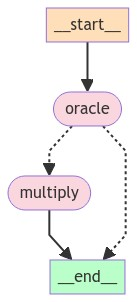

In [9]:
display(runnable)

In [10]:
input_text = "123 * 456等于多少?"
inputs = {"input": input_text, "chat_history": []}
runnable.invoke(inputs)

{'input': '123 * 456等于多少?',
 'chat_history': [],
 'agent_outcome': AgentAction(tool='multiply', tool_input='123,456', log='我需要使用multiply函数来计算两个数字的乘积。\nAction: multiply\nAction Input: "123,456'),
 'intermediate_steps': [(AgentAction(tool='multiply', tool_input='123,456', log='我需要使用multiply函数来计算两个数字的乘积。\nAction: multiply\nAction Input: "123,456'),
   56088)]}

In [11]:
input_text = "你叫什么名字？"
inputs = {"input": input_text, "chat_history": []}
runnable.invoke(inputs)

{'input': '你叫什么名字？',
 'chat_history': [],
 'agent_outcome': AgentFinish(return_values={'output': '我是一个AI助手。你可以称呼我为你的智能助理或小助手。如果你有特定问题需要解答或者帮助，请随时告诉我！'}, log='这个问题询问的是我的名字，但我不能提供一个具体的答案因为它需要我介绍自己。然而，作为一个AI助手，并没有我自己具名的特性。\n\nFinal Answer: 我是一个AI助手。你可以称呼我为你的智能助理或小助手。如果你有特定问题需要解答或者帮助，请随时告诉我！'),
 'intermediate_steps': []}